# Life Expectancy Analisys

In [12]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score

## Load the 3 data sets from Word Data Bank
***
### Country dataframe

In [13]:
country = pd.read_csv('data/Country.csv', index_col = None)
country.head(2)

,CountryCode,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,SpecialNotes,Region,IncomeGroup,WB-2 code,...,System of trade,Government Accounting concept,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,NaN,Latin America & Caribbean,High income,AW,...,General trade system,NaN,Enhanced General Data Dissemination System (e-...,2020 (expected),NaN,NaN,Yes,NaN,NaN,2018.0
1,AFE,Africa Eastern and Southern,Africa Eastern and Southern,Africa Eastern and Southern,ZH,NaN,"26 countries, stretching from the Red Sea in t...",NaN,NaN,ZH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
country.shape

(265, 30)

The Country data frame has 31 descriptor columns for each of the 247 rows (countries of groups of countries). Let's get a sense for how many individual countries exist and how many aggregate groupings (e.g. world, regions, income groupings). 

In [15]:
# ID aggregated rows by searching for 'aggregate' in the special notes column 
text = country.SpecialNotes.fillna('0')
len(text[text.str.contains('aggregate')])

30

### Load 'Series' dataframe (renamed as metrics)

In [16]:
metrics = pd.read_csv('data/Series.csv', index_col = None)

One row per series/metric, columns provide defintions, units, periodicity sources, etc. Now let's get a better sense for the key categories (and sub-categories) of development indicators.

Interested in health/life expactancy as the target indicators. SP.DYN.LE00.IN is a good fit: Life expectancy at birth, total (years)

In [17]:
metrics[metrics.IndicatorName.str.contains('Life expectancy')].head()

,Series Code,Topic,IndicatorName,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,Limitations and exceptions,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type
1255,SP.DYN.LE00.FE.IN,Health: Mortality,"Life expectancy at birth, female (years)",NaN,Life expectancy at birth indicates the number ...,NaN,Annual,NaN,NaN,Weighted average,Annual data series from United Nations Populat...,NaN,NaN,(1) United Nations Population Division. World ...,Life expectancy at birth used here is the aver...,Mortality rates for different age groups (infa...,NaN,NaN,NaN,CC BY-4.0
1256,SP.DYN.LE00.IN,Health: Mortality,"Life expectancy at birth, total (years)",NaN,Life expectancy at birth indicates the number ...,NaN,Annual,NaN,NaN,Weighted average,Annual data series from United Nations Populat...,NaN,NaN,(1) United Nations Population Division. World ...,Life expectancy at birth used here is the aver...,Mortality rates for different age groups (infa...,NaN,NaN,NaN,CC BY-4.0
1257,SP.DYN.LE00.MA.IN,Health: Mortality,"Life expectancy at birth, male (years)",NaN,Life expectancy at birth indicates the number ...,NaN,Annual,NaN,NaN,Weighted average,Annual data series from United Nations Populat...,NaN,NaN,(1) United Nations Population Division. World ...,Life expectancy at birth used here is the aver...,Mortality rates for different age groups (infa...,NaN,NaN,NaN,CC BY-4.0


Briefly view all the indicator categories that are available as predictors of Life Expectancy

In [18]:
# Highlevel topic categories
splitTopics = metrics.Topic.str.partition(':')
splitTopics.groupby([0,2]).size()

0                                           2                                                              
Economic Policy & Debt                       Balance of payments: Capital & financial account                  11
                                             Balance of payments: Current account: Balances                     4
                                             Balance of payments: Current account: Goods, services & income    22
                                             Balance of payments: Current account: Transfers                    7
                                             Balance of payments: Reserves & other items                        6
                                                                                                               ..
Social Protection & Labor                    Labor force structure                                             28
                                             Migration                                        

### Load 'Indicators' dataframe (renamed as 'df')
***

In [19]:
df = pd.read_csv('data/indicators1.csv', index_col=None)

#check availability of data and how missing values are handled (confirm unavailable data reported as'NaN')
df[df.IndicatorName.str.contains('GDP per capita')].groupby(['CountryName', 'IndicatorName']).size().unstack()

IndicatorName,GDP per capita (constant 2010 US$),GDP per capita (constant LCU),GDP per capita (current LCU),GDP per capita (current US$),GDP per capita growth (annual %),"GDP per capita, PPP (constant 2017 international $)","GDP per capita, PPP (current international $)","Government expenditure per student, primary (% of GDP per capita)","Government expenditure per student, secondary (% of GDP per capita)","Government expenditure per student, tertiary (% of GDP per capita)"
CountryName,,,,,,,,,,
Afghanistan,61,61,61,61,61,61,61,61,61,61
Africa Eastern and Southern,61,61,61,61,61,61,61,61,61,61
Africa Western and Central,61,61,61,61,61,61,61,61,61,61
Albania,61,61,61,61,61,61,61,61,61,61
Algeria,61,61,61,61,61,61,61,61,61,61
...,...,...,...,...,...,...,...,...,...,...
West Bank and Gaza,61,61,61,61,61,61,61,61,61,61
World,61,61,61,61,61,61,61,61,61,61
"Yemen, Rep.",61,61,61,61,61,61,61,61,61,61


## Data wrangling & inferential statistics
*** 

### Plot life expectancy trends for World Bank's country income groupings (high, med & low)

In [20]:
income = country[['CountryCode','IncomeGroup', 'SpecialNotes']]
df_Le = df.merge(income, left_on=df.CountryCode, right_on = income.CountryCode, how='outer')
df_Le = df_Le[(df_Le.IndicatorName =='Life expectancy at birth, total (years)') 
                              & (df_Le.SpecialNotes.str.contains('aggregate'))]

df_Le = pd.pivot_table(df_Le, values = 'Value', index='Year', columns='CountryName')


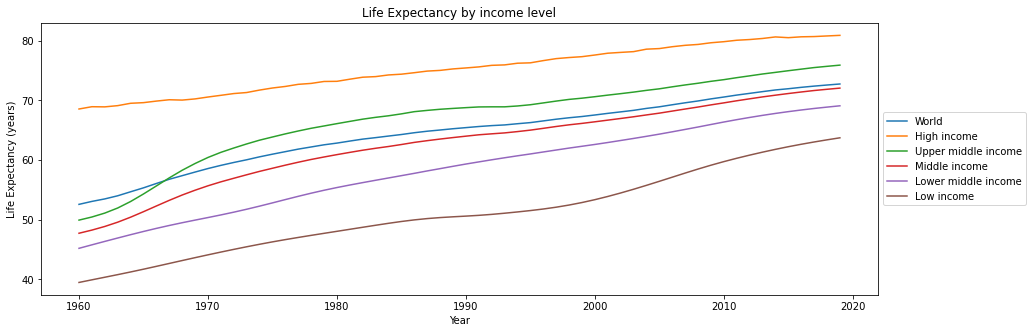

In [22]:
income_grps = ['World', 'High income', 'Upper middle income', 'Middle income','Lower middle income', 'Low income']

df_Le[income_grps].plot(figsize=(15,5))
plt.title('Life Expectancy by income level')
plt.ylabel('Life Expectancy (years)')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig('figure_1.jpg')

In [23]:
df_Le.columns

Index(['Arab World', 'Central Europe and the Baltics', 'East Asia & Pacific',
       'East Asia & Pacific (IDA & IBRD countries)', 'Euro area',
       'Europe & Central Asia', 'Europe & Central Asia (IDA & IBRD countries)',
       'European Union', 'Fragile and conflict affected situations',
       'Heavily indebted poor countries (HIPC)', 'High income', 'IBRD only',
       'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total',
       'Latin America & the Caribbean (IDA & IBRD countries)', 'Low income',
       'Lower middle income', 'Middle East & North Africa',
       'Middle East & North Africa (IDA & IBRD countries)', 'Middle income',
       'North America', 'Pacific island small states', 'Small states',
       'South Asia (IDA & IBRD)', 'Sub-Saharan Africa',
       'Sub-Saharan Africa (IDA & IBRD countries)', 'Upper middle income',
       'World'],
      dtype='object', name='CountryName')

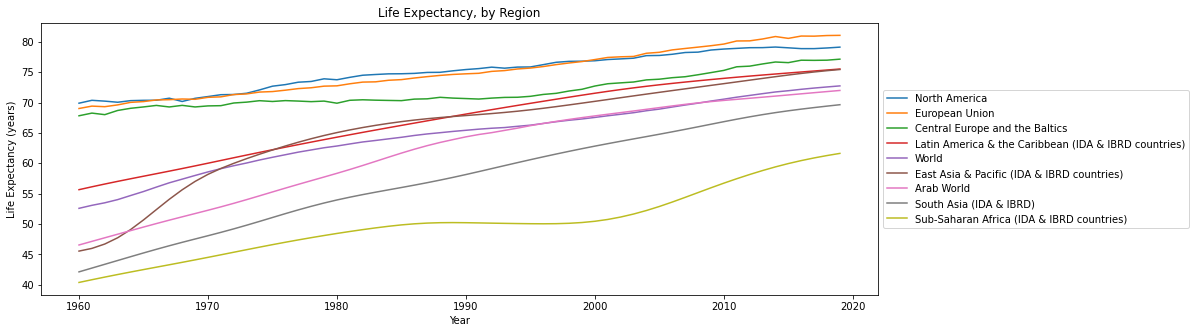

In [26]:
# regions =  ['North America','Europe & Central Asia','East Asia & Pacific', 
#         'Latin America & Caribbean','Middle East & North Africa',
#         'South Asia','Sub-Saharan Africa']

regions = ['North America','European Union','Central Europe and the Baltics', 
        'Latin America & the Caribbean (IDA & IBRD countries)','World',
        'East Asia & Pacific (IDA & IBRD countries)','Arab World',  
        'South Asia (IDA & IBRD)', 'Sub-Saharan Africa (IDA & IBRD countries)']

df_Le[regions].plot(figsize=(15,5))
plt.title('Life Expectancy, by Region')
plt.ylabel('Life Expectancy (years)')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.savefig('figure_2.jpg')

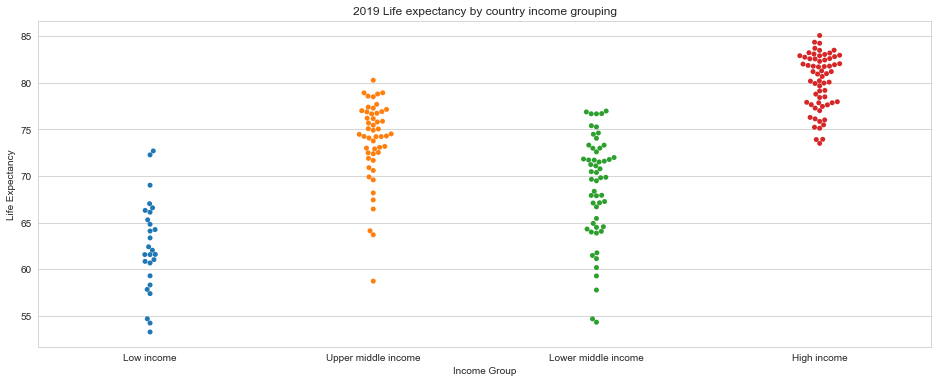

In [27]:
# Plot 2019 life expectancy for all countries, by income grouping
df_2019 = df.merge(income, left_on=df.CountryCode, right_on = income.CountryCode, how='outer')

df_2019 = df_2019[(df_2019.IndicatorName =='Life expectancy at birth, total (years)') & (df_2019.Year == 2019)]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))
_ = sns.swarmplot(x='IncomeGroup', y = 'Value', data = df_2019)
_ = plt.xlabel('Income Group')
_ = plt.ylabel('Life Expectancy')
_ = plt.title('2019 Life expectancy by country income grouping')

plt.savefig('figure_3.jpg')

In [57]:
df_2019.groupby(['IncomeGroup']).describe().unstack()[['Value']].round(1)

              IncomeGroup        
Value  count  High income            64.0
              Low income             27.0
              Lower middle income    55.0
              Upper middle income    51.0
       mean   High income            80.1
              Low income             62.6
              Lower middle income    68.8
              Upper middle income    73.8
       std    High income             3.0
              Low income              4.9
              Lower middle income     5.6
              Upper middle income     4.3
       min    High income            73.5
              Low income             53.3
              Lower middle income    54.3
              Upper middle income    58.7
       25%    High income            77.9
              Low income             60.0
              Lower middle income    64.7
              Upper middle income    72.4
       50%    High income            81.0
              Low income             62.0
              Lower middle income    69.9


## Machine learning: Predicting life expectancy with linear regression
*************
First, let's set up the dataframe with the top ~20 features that could be used to predict life expectancy. These features were selected to present a well-populated and diverse representation of the available development indicators. 

In [40]:
df.IndicatorCode

0              EG.CFT.ACCS.ZS
1              EG.ELC.ACCS.ZS
2           EG.ELC.ACCS.RU.ZS
3           EG.ELC.ACCS.UR.ZS
4              FX.OWN.TOTL.ZS
                  ...        
23414113       SG.VAW.REFU.ZS
23414114    SP.M15.2024.FE.ZS
23414115    SP.M18.2024.FE.ZS
23414116    SH.DYN.AIDS.FE.ZS
23414117       SH.HIV.INCD.YG
Name: IndicatorCode, Length: 23414118, dtype: object

#### Setting up the dataframe, and EDA on the data subset 

In [74]:
if "SH.STA.ACSN" in list(df.IndicatorCode):
    print("yes")

In [49]:
df.head()

,Unnamed: 0,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,1960,NaN
1,1,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,NaN
2,2,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,1960,NaN
3,3,Africa Eastern and Southern,AFE,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,1960,NaN
4,4,Africa Eastern and Southern,AFE,Account ownership at a financial institution o...,FX.OWN.TOTL.ZS,1960,NaN


In [61]:
# Reshape the data so features are column headers, and countries are rows
pivot.head()

IndicatorCode,BG.GSR.NFSV.GD.ZS,BM.GSR.CMCP.ZS,BM.GSR.FCTY.CD,BM.GSR.GNFS.CD,BM.GSR.INSF.ZS,BM.GSR.MRCH.CD,BM.GSR.NFSV.CD,BM.GSR.ROYL.CD,BM.GSR.TOTL.CD,BM.GSR.TRAN.ZS,...,per_sa_allsa.cov_q4_tot,per_sa_allsa.cov_q5_tot,per_si_allsi.adq_pop_tot,per_si_allsi.ben_q1_tot,per_si_allsi.cov_pop_tot,per_si_allsi.cov_q1_tot,per_si_allsi.cov_q2_tot,per_si_allsi.cov_q3_tot,per_si_allsi.cov_q4_tot,per_si_allsi.cov_q5_tot
CountryName,,,,,,,,,,,,,,,,,,,,,
Afghanistan,9.666175,6.467647,4.590459e+07,7.370792e+09,1.254347,6.158004e+09,1.212788e+09,4.778791e+06,7.416696e+09,76.018735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Africa Eastern and Southern,10.340806,14.494287,4.614712e+10,2.813080e+11,6.414988,2.239100e+11,5.717712e+10,2.114506e+09,3.293180e+11,40.893173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Africa Western and Central,12.417387,8.265393,NaN,2.325250e+11,3.579567,1.491560e+11,8.386902e+10,4.689242e+08,2.594500e+11,23.214341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,40.567361,5.979548,6.716615e+08,6.925815e+09,2.283095,4.532093e+09,2.393721e+09,3.478422e+07,7.597476e+09,10.452085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Algeria,7.748128,25.126955,5.271773e+09,5.425712e+10,2.026369,4.432055e+10,9.936571e+09,1.430987e+08,5.952889e+10,34.510501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
pivot.columns

Index(['BG.GSR.NFSV.GD.ZS', 'BM.GSR.CMCP.ZS', 'BM.GSR.FCTY.CD',
       'BM.GSR.GNFS.CD', 'BM.GSR.INSF.ZS', 'BM.GSR.MRCH.CD', 'BM.GSR.NFSV.CD',
       'BM.GSR.ROYL.CD', 'BM.GSR.TOTL.CD', 'BM.GSR.TRAN.ZS',
       ...
       'per_sa_allsa.cov_q4_tot', 'per_sa_allsa.cov_q5_tot',
       'per_si_allsi.adq_pop_tot', 'per_si_allsi.ben_q1_tot',
       'per_si_allsi.cov_pop_tot', 'per_si_allsi.cov_q1_tot',
       'per_si_allsi.cov_q2_tot', 'per_si_allsi.cov_q3_tot',
       'per_si_allsi.cov_q4_tot', 'per_si_allsi.cov_q5_tot'],
      dtype='object', name='IndicatorCode', length=1134)

In [64]:
if "SH.XPD.CHEX.GD.ZS" in list(pivot.columns):
    print("yes")

In [77]:
columns = {
            "SP.DYN.LE00.IN": "LifeExpectancy",
            'SH.XPD.CHEX.GD.ZS': "HealthSpend",
            'SP.ADO.TFRT': 'Adolescent_fertility',
            'NY.GDP.PCAP.CD': 'GDP',
            'SH.STA.BASS.ZS': 'Sanitation',
            'SP.RUR.TOTL.ZS': 'Rural_pop%',
            "NY.ADJ.AEDU.GN.ZS": "EduExp_percentGNI",
            'NY.ADJ.NNTY.KD.ZG': 'National_income_%growth',
#             'AG.LND.AGRI.ZS': 'Agricultural_land_%',
#             'AG.LND.ARBL.ZS': 'Arable_land_%',
#             'MS.MIL.TOTL.TF.ZS': 'Armed_forces_%',
            'SL.EMP.1524.SP.ZS': 'Employment_ratio_15',
            'SE.PRM.ENRR': 'Primary_edu',
            'SE.PRM.ENRL': 'Secondary_edu',
#             'SH.XPD.TOTL.ZS': 'Health_exp_%',
            'NE.IMP.GNFS.ZS': 'Imports_%GDP',
            'NV.IND.TOTL.ZS': 'Industry_%GDP',
            'IT.CEL.SETS.P2': 'Mobile_phones_per100',
#             'EN.POP.DNST': 'Population_density',
            'SM.POP.REFG': 'Refugee_population',
            'NE.TRD.GNFS.ZS': 'Trade_%GDP',
            'SL.UEM.TOTL.ZS': 'Unemployment_%'
#             'SH.MMR.RISK': 'Maternal_death_perc',
#             'SP.DYN.IMRT.IN': 'Mortality_infant _per1000',
#             'SH.DYN.NMRT': 'Mortality_neonatal_1000',
#             'SH.DYN.MORT': 'Mortality_sub5_1000'
          }

df.IndicatorCode = df.IndicatorCode.astype(str)
df.IndicatorName = df.IndicatorName.astype(str)

# Reshape the data so features are column headers, and countries are rows
pivot = df[df.Year==2017].pivot_table('Value','CountryName', 'IndicatorCode')

features = list(columns.keys())
df_features = pivot[features]
df_features.columns = df_features.columns.to_series()
flattened = pd.DataFrame(df_features.to_records())

df_ml = flattened.rename(index=str, columns=columns)

# Drop countries who do not have a life expectancy value 
df_ml = df_ml[pd.notnull(df_ml.LifeExpectancy)]
df_ml = df_ml.dropna(axis =0, how='any').drop('CountryName', axis = 1)

y = df_ml.LifeExpectancy.values.reshape(-1,1)
X = df_ml.drop(['LifeExpectancy'], axis = 1)

#View summary metrics of the features
X.describe().round(1)

,HealthSpend,Adolescent_fertility,GDP,Sanitation,Rural_pop%,EduExp_percentGNI,National_income_%growth,Employment_ratio_15,Primary_edu,Secondary_edu,Imports_%GDP,Industry_%GDP,Mobile_phones_per100,Refugee_population,Trade_%GDP,Unemployment_%
count,146.0,146.0,146.0,146.0,146.0,146.0,146.0,146.0,146.0,146.0,146.0,146.0,146.0,146.0,146.0,146.0
mean,6.8,43.9,14997.9,76.8,39.5,4.1,4.0,36.4,102.5,53521635.8,41.2,26.1,109.9,1881055.9,79.1,7.0
std,2.7,38.7,19561.1,26.6,20.1,1.4,3.5,13.2,10.1,126437321.5,23.9,7.7,26.5,4269683.7,48.9,4.8
min,2.3,1.4,293.0,8.3,0.0,1.1,-15.3,12.5,69.6,31981.0,12.5,5.2,39.5,5.0,18.9,0.1
25%,5.1,13.1,2150.0,60.1,22.3,3.1,2.3,26.3,98.8,482522.8,25.9,21.1,95.3,1661.2,49.5,4.2
50%,6.6,31.0,6334.6,88.2,38.6,4.0,3.9,35.9,101.9,2835342.0,33.0,25.7,113.9,45718.5,62.3,5.6
75%,8.2,65.1,18670.2,98.0,54.8,4.9,5.6,43.2,106.1,29338862.0,49.2,30.3,126.1,977165.5,91.5,8.2
max,17.0,186.5,107627.2,100.0,87.3,7.8,22.1,75.6,143.9,742000000.0,182.5,55.6,178.6,25383515.0,400.1,27.0


Visualize the correlation between all features by using the a heat maps and Pearson's correlation  

In [78]:
df_ml.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,LifeExpectancy,HealthSpend,Adolescent_fertility,GDP,Sanitation,Rural_pop%,EduExp_percentGNI,National_income_%growth,Employment_ratio_15,Primary_edu,Secondary_edu,Imports_%GDP,Industry_%GDP,Mobile_phones_per100,Refugee_population,Trade_%GDP,Unemployment_%
LifeExpectancy,1.0,0.41,-0.82,0.66,0.91,-0.73,0.33,-0.013,-0.06,-0.0081,-0.13,0.12,0.11,0.56,-0.13,0.23,0.0044
HealthSpend,0.41,1.0,-0.26,0.57,0.36,-0.42,0.36,-0.06,0.083,0.11,-0.14,0.013,-0.31,0.16,-0.093,0.02,0.14
Adolescent_fertility,-0.82,-0.26,1.0,-0.54,-0.84,0.58,-0.31,-0.083,0.29,-0.1,0.035,-0.21,-0.18,-0.55,0.066,-0.31,-0.14
GDP,0.66,0.57,-0.54,1.0,0.53,-0.61,0.43,-0.15,0.2,-0.011,-0.17,0.28,-0.14,0.34,-0.16,0.39,-0.098
Sanitation,0.91,0.36,-0.84,0.53,1.0,-0.71,0.38,-0.052,-0.23,-0.0034,-0.15,0.17,0.21,0.66,-0.13,0.26,0.17
Rural_pop%,-0.73,-0.42,0.58,-0.61,-0.71,1.0,-0.47,0.12,0.12,0.11,0.21,-0.17,-0.11,-0.54,0.17,-0.27,-0.088
EduExp_percentGNI,0.33,0.36,-0.31,0.43,0.38,-0.47,1.0,-0.24,-0.026,0.065,-0.24,0.29,-0.085,0.24,-0.18,0.31,0.17
National_income_%growth,-0.013,-0.06,-0.083,-0.15,-0.052,0.12,-0.24,1.0,0.01,0.23,0.11,-0.12,0.1,0.13,0.043,-0.12,-0.24
Employment_ratio_15,-0.06,0.083,0.29,0.2,-0.23,0.12,-0.026,0.01,1.0,0.066,0.0021,-0.13,-0.2,-0.2,-0.052,-0.14,-0.62
Primary_edu,-0.0081,0.11,-0.1,-0.011,-0.0034,0.11,0.065,0.23,0.066,1.0,0.05,-0.16,0.0022,0.15,-0.0043,-0.17,-0.014


Fit a linear regression model with all features, and view the coefficients.

In [79]:
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)
lr.score(X, y)

pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lr.coef_[0,:]})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,HealthSpend,-7.201160e-02
1,Adolescent_fertility,-2.837369e-02
2,GDP,7.236473e-05
3,Sanitation,2.023184e-01
4,Rural_pop%,-4.812000e-02
5,EduExp_percentGNI,-4.109455e-01
6,National_income_%growth,6.758775e-02
7,Employment_ratio_15,2.963276e-02
8,Primary_edu,-5.746799e-03
9,Secondary_edu,5.037014e-10


In [80]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
model_ols = ols('y ~ X', df_ml).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     77.59
Date:                Sat, 10 Jul 2021   Prob (F-statistic):           4.53e-58
Time:                        11:44:08   Log-Likelihood:                -326.90
No. Observations:                 146   AIC:                             687.8
Df Residuals:                     129   BIC:                             738.5
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     66.4218      3.356     19.793      0.000      59.782      73.061
X[0]          -0.0720      0.118     -0.609      0.543      -0.306       0.162
X[1]          -0.0284      0.012     -2.375      0.019      -0.052      -0.005
X[2]        7.236e-05   2.21e-05      3.276      0.001    2.87e-05       0.000
X[3]           0.2023      0.019     10.728      0.000       0.165       0.240
X[4]          -0.0481      0.017     -2.815      0.006      -0.082      -0.014
X[5]          -0.4109      0.185     -2.218      0.028      -0.777      -0.044
X[6]           0.0676      0.068      0.993      0.322      -0.067       0.202
X[7]           0.0296      0.024      1.240      0.217      -0.018       0.077
X[8]          -0.0057      0.023     -0.254      0.800      -0.051       0.039
X[9]        5.037e-10   4.06e-09      0.124      0.901   -7.52e-09    8.53e-09
X[10]         -0.0272      0.052     -0.525      0.601      -0.130       0.075
X[11]         -0.0590      0.032     -1.822      0.071      -0.123       0.005
X[12]         -0.0220      0.011     -1.962      0.052      -0.044       0.000
X[13]      -3.548e-08   1.18e-07     -0.302      0.763   -2.68e-07    1.97e-07
X[14]          0.0023      0.027      0.085      0.932      -0.051       0.055
X[15]         -0.0880      0.061     -1.431      0.155      -0.210       0.034
==============================================================================
Omnibus:                        1.698   Durbin-Watson:                   2.236
Prob(Omnibus):                  0.428   Jarque-Bera (JB):                1.425
Skew:                          -0.239   Prob(JB):                        0.490
Kurtosis:                       3.072   Cond. No.                     2.30e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Fit a regression based on top features (selected based on high correlation & low P)

In [81]:
X_top = df_ml.loc[:,('Sanitation', 'Rural_pop%')]
# X_top = df_ml.loc[:,('Sanitation', 'Rural_pop%', 'HealthSpend')]

X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size = 0.3, random_state=42) 
lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr.score(X_test, y_test)

import numpy as np 
cv_results = cross_val_score(lr, X_top, y, cv = 5)
print('Model accuracy with 5 cross validation folds: {}' .format(np.mean(cv_results)))

Model accuracy with 5 cross validation folds: 0.8279858442298679


In [82]:
# The coefficients
pd.DataFrame({'features': X_top.columns, 'estimatedCoefficients': lr.coef_[0,:]})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,Sanitation,0.216004
1,Rural_pop%,-0.046950


In [83]:
lr.intercept_

array([57.9882879])

Text(0.5, 1.0, 'Evaluation of model-predicted life expectancy')

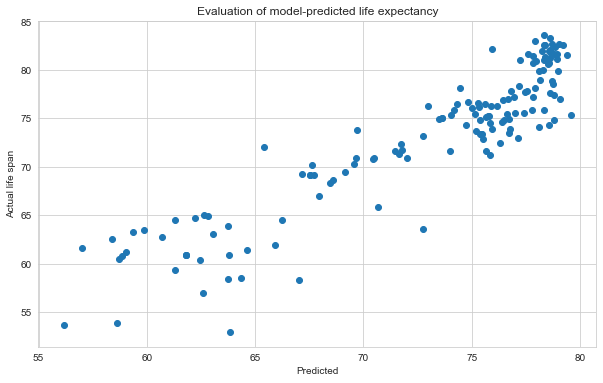

In [84]:
# scatter plot between actual and predicted life expectancy
y_predicted = lr.predict(X_top)
plt.figure(figsize=(10,6))
plt.scatter(y_predicted, y)
plt.xlabel("Predicted")
plt.ylabel("Actual life span")
plt.title('Evaluation of model-predicted life expectancy')

If we look just at Sanitation (below), we see that the Regression coefficient is 0.2485, meaning on average each 0.25% increase in the percent of the population with access to modern sanitation facilities, is associated with a one-year increase in life expectancy.

In [85]:
X_sani = df_ml.loc[:,('Sanitation')].values.reshape(-1,1)
X_top = df_ml.loc[:,('Sanitation', 'Rural_pop%')]

X_train, X_test, y_train, y_test = train_test_split(X_sani, y, test_size = 0.3, random_state=42) 
lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr.score(X_test, y_test)
 
cv_results = cross_val_score(lr, X_sani, y, cv = 5)
print('Model accuracy with 10 cross validation folds: {}' .format(np.mean(cv_results)))

Model accuracy with 10 cross validation folds: 0.8180268690735562


In [123]:
lr.coef_

array([[ 0.24664406]])

# Access to sanitation is the biggest drive for life expectancy
Let's dig into the age groups most affected by poor sanitation. We have Mortality rates for neonatals, infants and children under 5, as well as the maternal death rate. Repeating the steps above, we'll create a sub-set of the dataframe with the relevant columns, then run a correlation across this sub-set. 

In [89]:
# Create a sub-set of columns 
columns_san = {
            'SH.STA.HYGN.ZS': 'Sanitation_perc_access',
            "SP.DYN.LE00.IN": "LifeExpect_total",
            'SH.MMR.RISK': 'Maternal_death_perc',
            'SP.DYN.IMRT.IN': 'Mortality_infant _per1000',
            'SH.DYN.NMRT': 'Mortality_neonatal_1000',
            'SH.DYN.MORT': 'Mortality_sub5_1000',
          }

df.IndicatorCode = df.IndicatorCode.astype(str)
df.IndicatorName = df.IndicatorName.astype(str)

# piovt the 2013 data so the features are column headers
pivot_san = df[df.Year==2017].pivot_table('Value','CountryName', 'IndicatorCode')

features = list(columns_san.keys())
df_features = pivot[features]
df_features.columns = df_features.columns.to_series()
flattened = pd.DataFrame(df_features.to_records())

df_ml = flattened.rename(index=str, columns=columns_san)

# Drop countries who do not have a life expectancy value 
df_ml = df_ml[pd.notnull(df_ml.LifeExpect_total)]
df_ml = df_ml.dropna(axis =0, how='any').drop('CountryName', axis = 1)

In [90]:
df_ml.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,Sanitation_perc_access,LifeExpect_total,Maternal_death_perc,Mortality_infant _per1000,Mortality_neonatal_1000,Mortality_sub5_1000
Sanitation_perc_access,1.0,0.77,0.64,-0.73,-0.68,-0.73
LifeExpect_total,0.77,1.0,0.5,-0.92,-0.83,-0.92
Maternal_death_perc,0.64,0.5,1.0,-0.5,-0.52,-0.5
Mortality_infant _per1000,-0.73,-0.92,-0.5,1.0,0.92,0.99
Mortality_neonatal_1000,-0.68,-0.83,-0.52,0.92,1.0,0.9
Mortality_sub5_1000,-0.73,-0.92,-0.5,0.99,0.9,1.0
